In [11]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("IBM _HR_Cleaned.csv")

In [9]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)

print("\nSample Data:\n", df.head())

print("\nMissing Values:\n", df.isnull().sum())

print("\nStatistical Summary:\n", df.describe(include='all'))

Shape: (1470, 38)

Columns: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'TenureRatio', 'overtimr binary', 'Age grouping']

Data Types:
 Age                           int64
Attrition                    object
BusinessTravel               object
DailyRate                     int64
Department                   object
DistanceFromHome              int64
Education                     int64
EducationField               object
E

In [13]:
df['Attrition_flag'] = df['Attrition'].map({'Yes': 1, 'No': 0})

In [15]:
drop_cols = ['Attrition', 'EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours']
drop_cols = [col for col in drop_cols if col in df.columns] 
df = df.drop(columns=drop_cols)


In [19]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Attrition_flag') 

In [23]:
X = df.drop(columns=['Attrition_flag'])
y = df['Attrition_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)


In [25]:
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_reg_pipeline.fit(X_train, y_train)

# Predictions & metrics
y_pred_lr = log_reg_pipeline.predict(X_test)
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       247
           1       0.36      0.64      0.46        47

    accuracy                           0.76       294
   macro avg       0.64      0.71      0.65       294
weighted avg       0.83      0.76      0.79       294

ROC-AUC: 0.8072185373417177


In [27]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200, class_weight='balanced', random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.45      0.11      0.17        47

    accuracy                           0.84       294
   macro avg       0.65      0.54      0.54       294
weighted avg       0.79      0.84      0.79       294

ROC-AUC: 0.7729778620036178


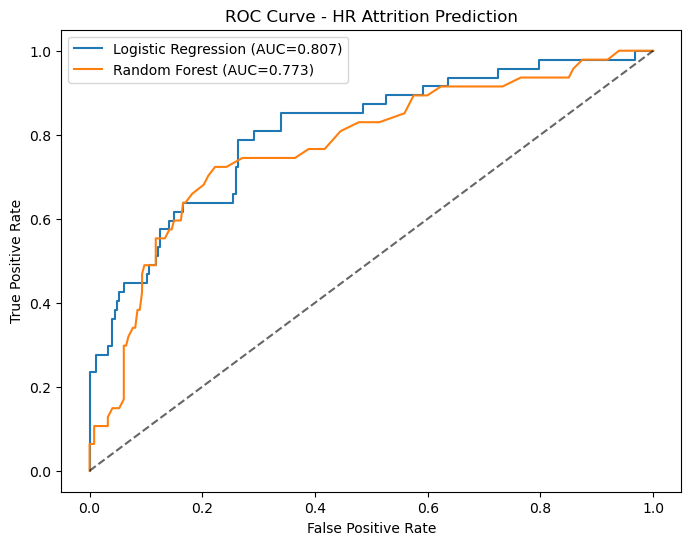

In [29]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={roc_auc_score(y_test, y_proba_lr):.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={roc_auc_score(y_test, y_proba_rf):.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - HR Attrition Prediction")
plt.legend()
plt.show()


=== Top 20 Important Features (Random Forest) ===
                     Feature  Importance
9              MonthlyIncome    0.065187
0                        Age    0.055513
1                  DailyRate    0.052450
16         TotalWorkingYears    0.049509
19            YearsAtCompany    0.049492
2           DistanceFromHome    0.042442
10               MonthlyRate    0.041777
5                 HourlyRate    0.041548
22      YearsWithCurrManager    0.037531
11        NumCompaniesWorked    0.035223
24           overtimr binary    0.031521
12         PercentSalaryHike    0.031192
15          StockOptionLevel    0.030761
20        YearsInCurrentRole    0.030411
45              OverTime_Yes    0.028539
4    EnvironmentSatisfaction    0.025361
7                   JobLevel    0.025083
8            JobSatisfaction    0.024191
18           WorkLifeBalance    0.021115
14  RelationshipSatisfaction    0.020976


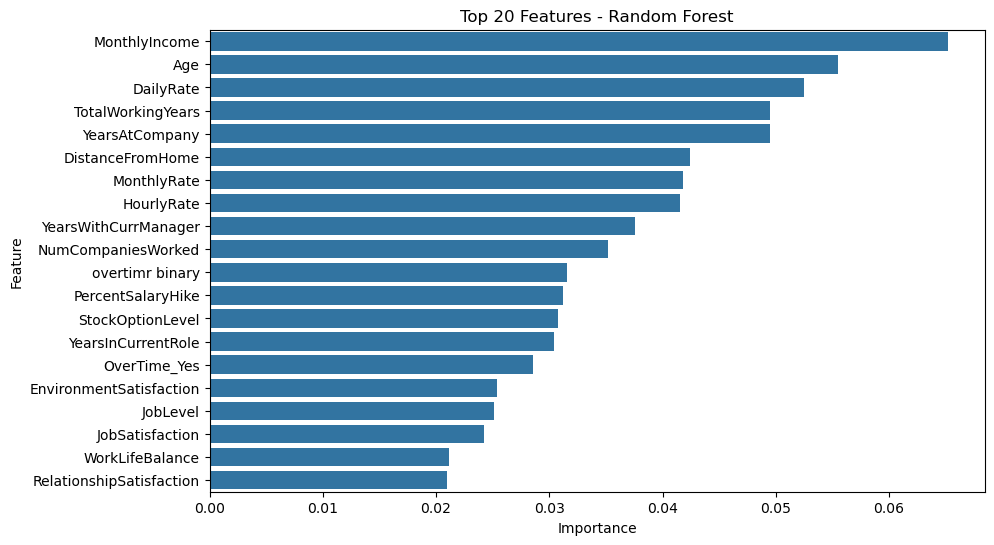

In [33]:
ohe_features = rf_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(ohe_features)

importances = rf_pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n=== Top 20 Important Features (Random Forest) ===")
print(feature_importance_df.head(20))


plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title("Top 20 Features - Random Forest")
plt.show()

###SHAP EXPLAINABILITY

In [48]:
!pip install shap


   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 6.0 MB/s eta 0:00:00


In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import shap


In [90]:
df = pd.read_csv("IBM _HR_Cleaned.csv")
print(df.columns.tolist())

['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'TenureRatio', 'overtimr binary', 'Age grouping']


In [94]:
if 'EmployeeNumber' in df.columns:
    df.drop(columns=['EmployeeNumber'], inplace=True)

df = df.dropna(subset=['Attrition'])

In [96]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

df.dropna(inplace=True)

In [98]:
X = df.drop(columns=['Attrition'])

X = pd.get_dummies(X, drop_first=True)

y = df['Attrition']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [104]:
y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[253   2]
 [ 36   3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       255
           1       0.60      0.08      0.14        39

    accuracy                           0.87       294
   macro avg       0.74      0.53      0.53       294
weighted avg       0.84      0.87      0.82       294



In [106]:
print(df.shape)

(1470, 37)
